In [1]:
import gammapy
gammapy.__version__

import sys, logging
import gammapy
import numpy as np
import astropy
import regions
from regions import CircleSkyRegion, RectangleSkyRegion
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.stats import norm

from pathlib import Path
from gammapy.data import DataStore
from gammapy.analysis import Analysis, AnalysisConfig
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
    MapDatasetOnOff,
    MapDataset
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    Model, 
    Models,
    FoVBackgroundModel,
    GaussianSpatialModel
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    MapDatasetMaker,
    FoVBackgroundMaker
    )
from gammapy.estimators import FluxPointsEstimator, ExcessMapEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

import scipy
log = logging.getLogger(__name__)

In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps/")

In [3]:
obs_ids = [110380, 111140, 111159]
observations = data_store.get_observations(obs_ids)

No HDU found matching: OBS_ID = 110380, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 111140, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 111159, HDU_TYPE = rad_max, HDU_CLASS = None


In [4]:
def create_ds(observations, name='stacked'):
    offset_max = 2.5*u.deg
    maker = MapDatasetMaker(
            selection=["counts", "exposure", 'edisp',  "psf", "background"])
    safe_maker = SafeMaskMaker(
        methods=['offset-max', 'aeff-max', "bkg-peak"], offset_max=offset_max, aeff_percent=10
    )

    datasets = []
    
    for obs in observations:
        
        stacked = MapDataset.create(geom=geom,  name=f"impact-{obs.obs_id}")
        
        cutout = stacked.cutout(
            obs.pointing_radec, width=2. * offset_max, name=f"impact-{obs.obs_id}"
        )
        dataset = maker.run(cutout, obs)
        # The data quality cut is applied
        dataset = safe_maker.run(dataset, obs)
        print(dataset.name, "  ", np.nanmin(dataset.energy_range_safe[0].data))
        stacked.stack(dataset)
        datasets.append(stacked)

    
    return Datasets(datasets)



## Start at 300 GeV

In [5]:
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 10, unit="TeV", per_decade=True)

geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 20, unit="TeV", per_decade=True, name="energy_true"
)

In [6]:
datasets = create_ds(observations)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


impact-110380    0.3735090906023128


Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


impact-111140    0.3735090906023128


Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


impact-111159    0.3735090906023128


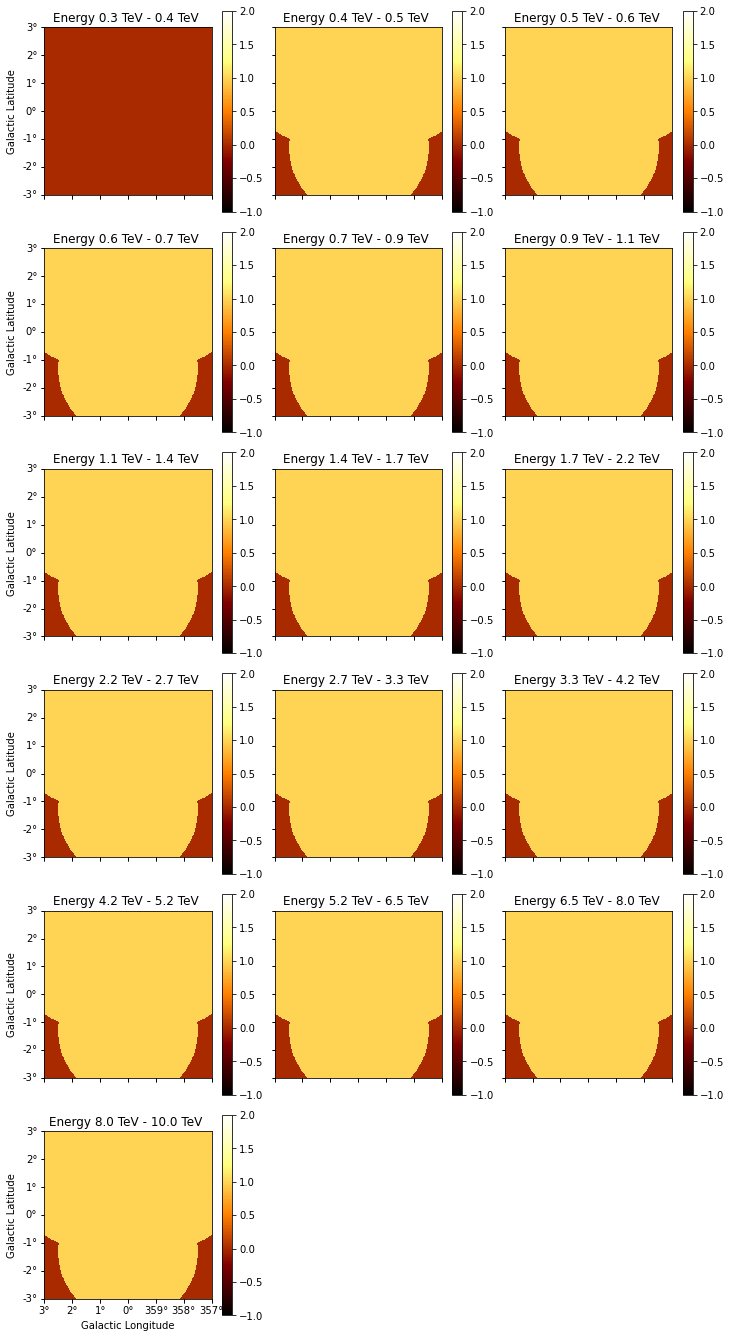

In [7]:
stacked = datasets.stack_reduce()
stacked.mask_safe.plot_grid(vmin=-1, vmax=2, add_cbar=True);

## Start at 1 TeV


In [8]:
energy_axis = MapAxis.from_energy_bounds(1, 10.0, 10, unit="TeV", per_decade=True)

geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(4, 4),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 20, unit="TeV", per_decade=True, name="energy_true"
)

In [9]:
datasets = create_ds(observations)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


impact-110380    1.2589254117941673


Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


impact-111140    1.2589254117941673
impact-111159    1.2589254117941673


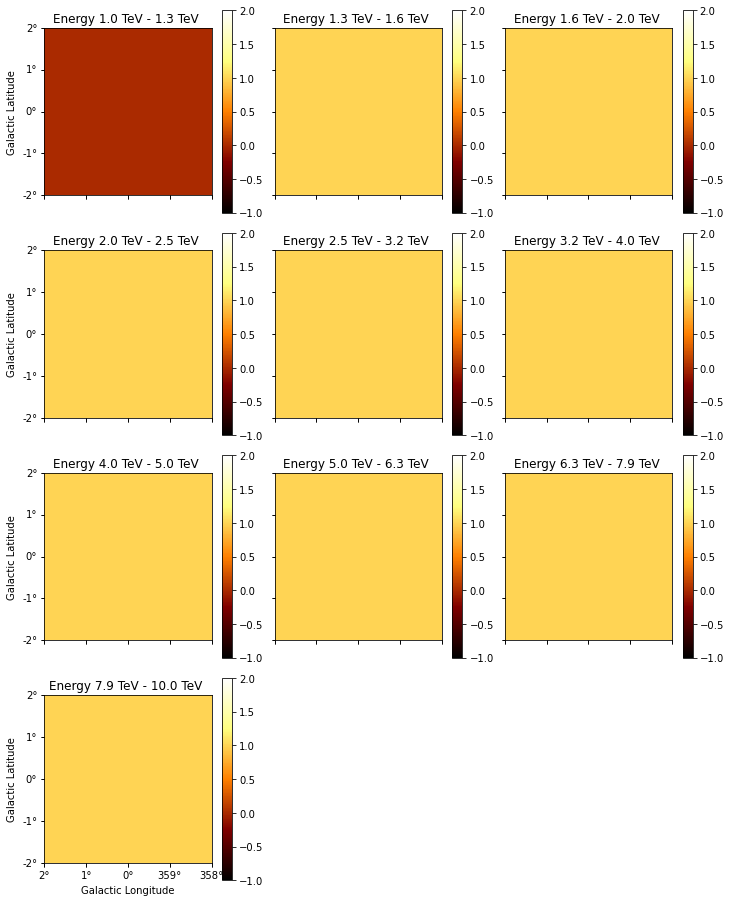

In [10]:
stacked = datasets.stack_reduce()
stacked.mask_safe.plot_grid(vmin=-1, vmax=2, add_cbar=True);